<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Causal Inference In Statistics - A Primer</h1>
        <h1>1.5 Structural Causal Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
    <div style="float: right; margin-right:10px;"> <p><a href="https://amzn.to/3gsFlkO" target=_blank><img src='data/causality.jpeg' width='100px'>
        <!--Amazon Affiliate Link--></a></p></div>
</div>

In [4]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import sklearn
from sklearn.linear_model import LinearRegression
from CausalModel import CausalModel

import watermark

%load_ext watermark
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


We start by print out the versions of the libraries we're using for future reference

In [5]:
%watermark -n -v -m -g -iv

autopep8   1.5
pandas     1.0.1
json       2.0.9
sklearn    0.22.1
watermark  2.0.2
numpy      1.18.1
matplotlib 3.1.3
Fri Jul 24 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 7bb21d92754ca48aa8a201cf2e70b750085be46b


Load default figure style

In [6]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Modeling Causal Assumptions

We can load the structure of this model directly from disk:

In [7]:
G = CausalModel('dags/Primer.Fig.1.9.dot')

And plot it quickly

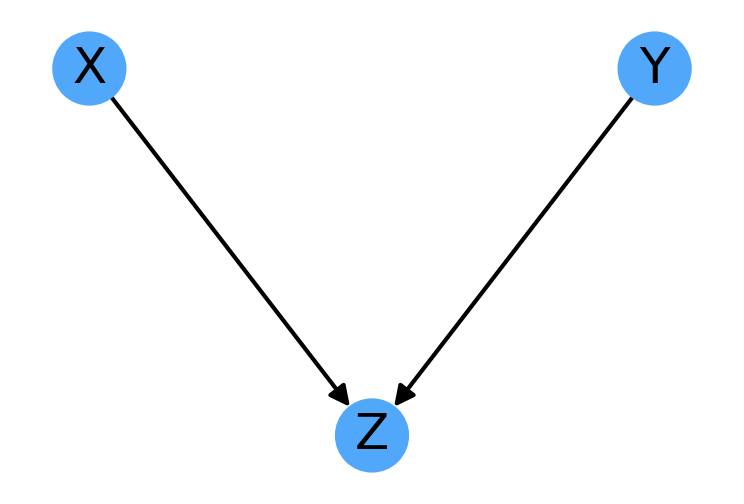

In [8]:
fig, ax = plt.subplots(1, figsize=(3, 2.2))
G.plot(ax=ax, legend=False)

We generate our fake data

In [9]:
x = np.linspace(20, 30)
y = np.linspace(100, 300, 50)
X, Y = np.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()

Z = 2*X+3*Y

model = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

And inspect it:

In [10]:
model

,X,Y,Z
0,20.000000,100.0,340.000000
1,20.204082,100.0,340.408163
2,20.408163,100.0,340.816327
3,20.612245,100.0,341.224490
4,20.816327,100.0,341.632653
...,...,...,...
2495,29.183673,300.0,958.367347
2496,29.387755,300.0,958.775510
2497,29.591837,300.0,959.183673
2498,29.795918,300.0,959.591837


And to go the other way, we simply perform a Linear Regression fit

In [11]:
lm = LinearRegression()
lm.fit(model[['X', 'Y']], model[['Z']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

From where we easily extract the coefficients of our model for $f_Z$

In [13]:
print(lm.coef_[0])

[2. 3.]


Let us now build the model for SCM 1.5.3

In [34]:
G2 = CausalModel()
G2.add_causation(r'$U_X$', 'X')
G2.add_causation(r'$U_Y$', 'Y')
G2.add_causation(r'$U_Z$', 'Z')
G2.add_causation('X', 'Y')
G2.add_causation('Y', 'Z')
G2.pos = {r'$U_X$': (-1, 1), r'$U_Y$':(0,1), r'$U_Z$': (1,1), 'X': (-1, 0), 'Y':(0,0), 'Z':(1, 0)}

Visualize it

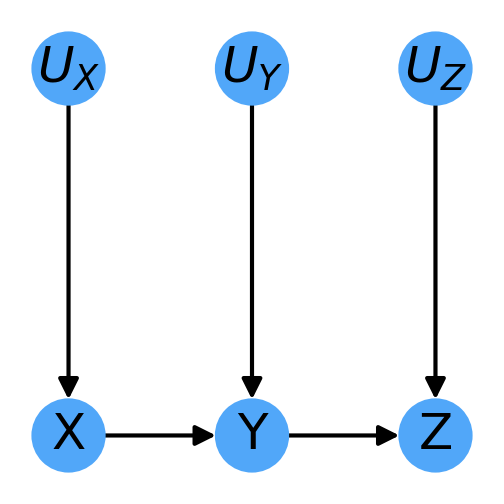

In [35]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
G2.plot(ax=ax)

And save it as a dot file so that we can reuse it easily

In [36]:
G2.save_model('dags/Primer.SCM.1.5.3.dot')

Since this is a stochastic model, we have to use random numbers. We'll assume that the exogenous variables are normally distributed and generate 1000 values for each of them

In [46]:
N = 10000 
Ux = np.random.normal(size=N) 
Uy = np.random.normal(size=N)
Uz = np.random.normal(size=N)

And define the 3 functions that determine the values of X, Y and Z

In [47]:
fX = lambda ux: ux
fY = lambda x, uy: 1/3*x+uy
fZ = lambda y, uz: 1/16*y+uz

In [48]:
X = fX(Ux)
Y = fY(X, Uy)
Z = fZ(Y, Uz)

model = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

In [49]:
model

,X,Y,Z
0,2.314854,1.187864,-1.490274
1,1.144085,0.250981,-0.527358
2,-0.939983,0.559766,0.522602
3,2.480030,0.016573,-0.200299
4,-0.554046,-0.034472,0.415229
...,...,...,...
9995,-1.189819,-0.390255,-0.448793
9996,0.332314,1.860918,0.533191
9997,0.867750,0.575188,2.195851
9998,-0.892905,-1.333559,0.748093


If we observe that Y=3, then the expected (mean) value of Z is:

In [54]:
Z_Y3 = np.mean(fZ(3, Uz))
print(Z_Y3)

0.1797197150272186


Which is close to the analytically expected value of 1/16=0.1875

If, on the other hand, we observe that $X=3$ then our calculation requires 2 steps:

In [56]:
Y_X3 = fY(3, Uy)
Z_X3 = np.mean(fZ(Y_X3, Uz))
print(Z_X3)

0.05451893946106389


Which again is close to the expected analytical value of 1/16=0.0625

In [57]:
lm = LinearRegression()
lm.fit(model[['X']], model['Z'])
lm.predict([[3]])

array([0.04075292])

We can also run the computation in the opposite direction (contrary to the direction of causality). If we want to know the expected value of $X$ given that $Y=2$

In [31]:
lm = LinearRegression(fit_intercept=True)
lm.fit(model[['Y']], model[['Z']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
lm.predict([[3]])

array([[0.20091412]])

In [33]:
3/16

0.1875

In [ ]:
lm = LinearRegression(fit_intercept=True)
lm.fit(model[['Y']], model[['Z']])

In [37]:
lm = LinearRegression()
lm.fit(model[['X', 'Z']], model['Y'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
lm.predict([[1, 3]])

array([0.57354923])

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>